# Instagram Dataframe Creator

In [13]:
import pandas as pd
import os
from datetime import datetime
import re
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import subprocess
import names
from selenium.webdriver.common.by import By
import time
import math
import random 
import json
import matplotlib.pyplot as plt

In [2]:
email = "maskradiogreece@gmail.com"
password = "code1234567"
now = datetime.now()

In [3]:
recorded_time = round(datetime.timestamp(now))
def scrap_profile(name,count):
    try:
        command = "instagram-scraper --user " + name + " -u " + email + " -p " + password + " -m " + str(count) + " --cookiejar cookies --media-metadata -t none -d " + str(recorded_time)  
        subprocess.check_output(command)
    except subprocess.CalledProcessError as e:
        print(f"Couldn't fetch data for {name}")
        raise Exception("Sorry, papala")

In [4]:
driver = webdriver.Chrome("../Data/chromedriver_win32/chromedriver.exe")
driver.maximize_window()
driver.get("https://www.instagram.com/")
time.sleep(5)
buttons = driver.find_elements_by_tag_name("button")
time.sleep(1)
buttons[2].click()
login_inputs = driver.find_elements_by_tag_name("input")
time.sleep(1)
login_inputs[0].send_keys(email)
time.sleep(1)
login_inputs[1].send_keys(password)
time.sleep(1)
buttons[0].click()
time.sleep(5)
notification_button = driver.find_elements(By.XPATH, '//button[text()="Όχι τώρα"]')
time.sleep(1)
notification_button[0].click()

In [ ]:
time.sleep(10)
total_count = 0
loop = 1
fails = 0
while True:
    driver.get("https://www.instagram.com/")
    inputs = driver.find_elements_by_tag_name("input")
    # The 3rd one is the search 
    search = inputs[2]
    random_name = names.get_first_name() 
    search.send_keys(random_name)
    time.sleep(10)
    # Get List of Users
    user_list = driver.find_elements(By.XPATH, '//div[@role="none"]')
    # Create List 
    profile_links = []
    for user in user_list:
        link = user.find_element_by_tag_name("a")
        link = link.get_attribute("href")
        if link.find("explore") == -1:
            profile_links.append(link)
    searched_links = pd.read_csv("./Links.csv")
    searched_links = searched_links["Links"].to_list()
    print(f"Going to scrap {len(profile_links)} profiles searching for {random_name}")
    for link in profile_links:
        name = link.split("/")[3]
        if link in searched_links:
            print(f"SKIPPING ====> USER {name} ALREADY SCRAPED ")
            continue
        driver.get(link);
        try:
            is_private = driver.find_element(By.XPATH, "//*[text()[contains(., 'Αυτός ο λογαριασμός είναι ιδιωτικός')]]" )
            continue 
        except: 
            post = driver.find_element(By.XPATH, "//*[text()[contains(., 'δημοσιεύσεις') or contains(., 'δημοσίευση')]]" )
            num_posts = int(post.find_element_by_tag_name("span").get_attribute("innerHTML").replace(",",""))
            if num_posts < 20:
                print(f"SKIPPING ====> USER {name} HAS LESS THAN 20 POSTS")
                continue
            get_num_posts = min(num_posts,200)
            print(f"FETCHING ====> Getting {get_num_posts} from {name}")
            try:
                scrap_profile(name,get_num_posts)
                total_count += get_num_posts
                print(f"TOTAL ====> Aquired {total_count} data from {loop} users")
                loop += 1
                time.sleep(random.randint(10,60))
            except:
                print(f"There was error on getting {name}")
                fails += 1
                if fails == 4:
                    print("Failed 4 times . EXITING")
                    exit()
        searched_links.append(link)
        df = pd.DataFrame(searched_links,columns=["Links"])
        df.to_csv('./Links.csv',index=False)

Going to scrap 49 profiles searching for Nellie
SKIPPING ====> USER nellie.kn HAS LESS THAN 20 POSTS
FETCHING ====> Getting 200 from nelliecronenn
TOTAL ====> Aquired 200 data from 1 users
FETCHING ====> Getting 120 from _nellie_thecockerspaniel
TOTAL ====> Aquired 320 data from 2 users
FETCHING ====> Getting 200 from nelliebenner
TOTAL ====> Aquired 520 data from 3 users
FETCHING ====> Getting 200 from nellielynnfit
TOTAL ====> Aquired 720 data from 4 users
FETCHING ====> Getting 200 from nelliediamond
TOTAL ====> Aquired 920 data from 5 users
FETCHING ====> Getting 116 from nellie.theitaliangreyhound
TOTAL ====> Aquired 1036 data from 6 users
FETCHING ====> Getting 200 from hellenne__
TOTAL ====> Aquired 1236 data from 7 users
FETCHING ====> Getting 30 from landqvistnellie
TOTAL ====> Aquired 1266 data from 8 users
FETCHING ====> Getting 169 from nelliepedersen
TOTAL ====> Aquired 1435 data from 9 users
FETCHING ====> Getting 200 from missnelliedahl
TOTAL ====> Aquired 1635 data from

In [2]:
main_folder = "JsonData"

user_uuid = []
images = []
likes = []
like_percentages = []
days_count = []
num_of_tags = []
num_of_comments = []
date_posted = []
type = []
count = 1
for folder_name in os.listdir(f"./{main_folder}/"):
    folder_time_recorded = datetime.fromtimestamp(int(folder_name))
    for file_name in os.listdir(f"./{main_folder}/{folder_name}/"):
        file = open(f'./{main_folder}/{folder_name}/{file_name}', encoding="utf8")
        data = json.load(file)
        sub_likes = []
        i = 1
        for item in data["GraphImages"]:
            if item["__typename"] == "GraphImage":
                type.append("Image")
            elif item["__typename"] == "GraphVideo":
                type.append("Video")
            else:
                type.append("Images")
            # If the post is at least 2 days old then add it to data or else skip it
            user_uuid.append(count)
            likes.append(item["edge_media_preview_like"]["count"])
            try:
                num_of_tags.append(len(item["tags"]))
            except:
                num_of_tags.append(0)
            num_of_comments.append(item["edge_media_to_comment"]["count"])
            sub_likes.append(item["edge_media_preview_like"]["count"])
            date = datetime.fromtimestamp(item["taken_at_timestamp"])
            date_posted.append(date)
            days_count.append((datetime.today() - datetime.fromtimestamp(item["taken_at_timestamp"])).days)
        maxLikes = max(sub_likes)
        sub_like_percentages = []
        for like in sub_likes:
            sub_like_percentages.append(round(like/maxLikes,2))
        like_percentages += sub_like_percentages
        count += 1
        file.close()

In [7]:
df = pd.DataFrame(user_uuid,columns=["User uuid"])

In [8]:
df["Likes"] = likes
df["Days passed from post"] = days_count
df["Likes Score"] = like_percentages
df["Type"] = type
df["Numer of Tags"] = num_of_tags
df["Numer of Comments"] = num_of_comments
df["Date Posted"] = date_posted
df['Year'] = df['Date Posted'].dt.year
df['Month'] = df['Date Posted'].dt.month
df['Day'] = df['Date Posted'].dt.day
df['Hour'] = df['Date Posted'].dt.hour
df['Minute'] = df['Date Posted'].dt.minute

In [9]:
df.head()

,User uuid,Likes,Days passed from post,Likes Score,Type,Numer of Tags,Numer of Comments,Date Posted,Year,Month,Day,Hour,Minute
0,1,506,642,0.74,Image,3,11,2019-05-12 21:18:39,2019,5,12,21,18
1,1,385,642,0.57,Image,0,1,2019-05-12 14:25:55,2019,5,12,14,25
2,1,373,651,0.55,Images,4,15,2019-05-03 15:18:37,2019,5,3,15,18
3,1,312,652,0.46,Images,4,1,2019-05-02 16:40:38,2019,5,2,16,40
4,1,513,659,0.75,Images,5,0,2019-04-25 16:51:58,2019,4,25,16,51


In [11]:
df.to_csv("./InstagramData.csv")

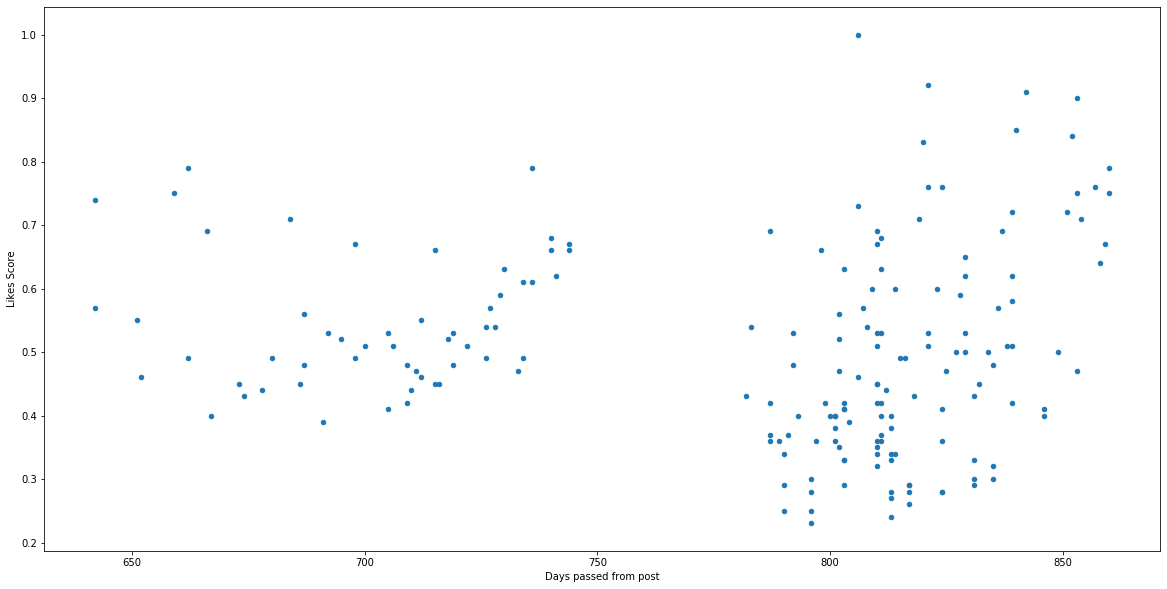

In [19]:
df[df["User uuid"]==1].plot.scatter("Days passed from post","Likes Score",figsize=(20,10))